# Imports

In [1]:
# Used for loading data, statistics and clustering,
import pandas as pd
import numpy as np

In [2]:
# Not used directly in jupyter but used in the script files
# created and tested by jupyter. Used by mapreduce scripts.
import mrjob
from mrjob.job import MRJob
from mrjob.step import MRStep

In [3]:
# Used to make sql queries and print them nicely.
import sqlite3
from textwrap import indent,dedent

In [4]:
# Visualization
import matplotlib.pyplot as plt

# Create Folders

In [5]:
import os
for directory in ["./Scripts", "./Sqlite"]:
    if not os.path.exists(directory):
        os.makedirs(directory)

# Clean and extract Data

In [6]:
filepath_read = "Data/Wikipedia_Editor_Survey_2012_-_anonymized_dataset.csv"
filepath_save = "Data/Wikipedia_Editor_Survey_2012_-_anonymized_dataset_clean.csv"
time,age = columns = ["Q20_1_TEXT", "Q21"]

df = pd.read_csv(filepath_read, low_memory=False)

df = df[[age,time]] # Extract columns

df.loc[df[age] == "Decline to state", age] = np.nan # turn "decline" into nan
df.loc[df[age] == "_ 18", age] = 0                  # less than 18 => 0
df.loc[df[age] == "> 99", age] = 100                # More than 99 => 100

df.dropna(inplace=True)    # Drop NaN / None / Null
df.drop([0], inplace=True) # Remove first row with string questions
df = df.astype(int)        # Convert all to int

df.to_csv(filepath_save, index=False, header=False)

# Display sample of data saved
df.reset_index(drop=True, inplace=True)
df.rename(columns={'Q20_1_TEXT':'Time','Q21':'Age',}, inplace=True)
df.head()

,Age,Time
0,26,0
1,71,40
2,27,0
3,18,2
4,42,0


### Example Load Clean Data Pandas

In [7]:
filepath = "Data/Wikipedia_Editor_Survey_2012_-_anonymized_dataset_clean.csv"
names = ["Age","Time"]

df = pd.read_csv(filepath, names=names, dtype=dict((n,int) for n in names))

df.tail()

,Age,Time
9675,28,10
9676,38,1
9677,32,2
9678,60,5
9679,26,33


### Example Load Clean Data Open(...)

In [8]:
with open(filepath) as f:
    for i,line in enumerate(f):
        line = line.rstrip()
        answers = line.split(',')
        print(f'line {i}: Age:{answers[0]:>3}, Time:{answers[1]:>3}, Raw text: "{line}\\n"')
        if i == 4:
            break

line 0: Age: 26, Time:  0, Raw text: "26,0\n"
line 1: Age: 71, Time: 40, Raw text: "71,40\n"
line 2: Age: 27, Time:  0, Raw text: "27,0\n"
line 3: Age: 18, Time:  2, Raw text: "18,2\n"
line 4: Age: 42, Time:  0, Raw text: "42,0\n"


# Summary statistics

Serves to provide a simple overview of the data-set rather than be an actual part of the implementation.

In [9]:
def load_points(column = 0, filepath = 'Data/Wikipedia_Editor_Survey_2012_-_anonymized_dataset_clean.csv'):
    
    # Load points using the example provided earlier
    with open(filepath) as f:
        for i,line in enumerate(f):
            cols = line.rstrip().split(',')
            yield int(cols[column])
            
age_points  = list(load_points(0))
time_points = list(load_points(1))

In [10]:
def summary(points, title):
    print(f'Summary staticstics for {title}')
    print('Mean: %0.2f +- %0.2f' % (np.mean(points), np.std(points)))
    print('Min: %d, Max: %d\n' % (np.min(points), np.max(points)))

summary(age_points, 'Age')
summary(time_points, 'Time')
print(f'Completed summary statistics for {len(age_points)} respondents!')

Summary staticstics for Age
Mean: 31.93 +- 19.33
Min: 0, Max: 100

Summary staticstics for Time
Mean: 4.69 +- 8.90
Min: 0, Max: 96

Completed summary statistics for 9680 respondents!


# Clustering

### Un-parallelized implementation of K-means

In [11]:
import numpy as np

MAX_AGE  = 100
MAX_TIME = 96

CLUSTER_COUNT = 6
MAX_ITERATIONS = 100
PRECISION = 2

def nearest_centroid(point, centroids):
    dists = np.array([abs(centroid - point) for centroid in centroids])
    return np.argmin(dists)

def k_means(points, k = CLUSTER_COUNT, max_iterations = MAX_ITERATIONS, precision = PRECISION):
    
    # Optionally change precision for output
    np.set_printoptions(precision=precision)
    
    # Initialize centroids uniformly
    centroids = np.array([idx*MAX_AGE/(k+0.5) for idx in range(k)])
    
    def update_centroids():
        return np.array([np.mean(cluster) for cluster in clusters])
    
    def is_converged():
        for i, centroid in enumerate(centroids):
            if centroid != updated_centroids[i]:
                return False
        return True
    
    for iteration in range(max_iterations):
        
        # Initialize clean clusters
        clusters = [[] for idx in range(k)]
        
        # Assign points to nearest cluster and update
        for point in points:
            clusters[nearest_centroid(point, centroids)].append(point)
        updated_centroids = update_centroids()

        if is_converged():
            print(f'Converged after {iteration+1} iterations with the following centroids:\n{updated_centroids}\n')
            return updated_centroids
    
        centroids = updated_centroids
    
    return centroids

# Compute centroids from previously loaded points
age_centroids  = k_means(age_points)
time_centroids = k_means(time_points)

def get_upper_bounds(centroids, xmin, xmax):
    upper_bound = []
    prev_centroid = None
    for i in range(xmin, xmax):
        centroid = nearest_centroid(i, centroids)
        if centroid != prev_centroid and centroid > 0:
            upper_bound.append(i)
        prev_centroid = centroid
    return upper_bound

# Get upper-bound representation of centroids for each column
print('Upper bounds for age: ', get_upper_bounds(age_centroids, 0, MAX_AGE))
print('Upper bounds for time:', get_upper_bounds(time_centroids, 0, MAX_TIME))

Converged after 8 iterations with the following centroids:
[ 0.   22.41 31.48 43.79 56.65 69.67]

Converged after 3 iterations with the following centroids:
[ 1.43 13.21 28.79 44.54 58.29 77.46]

Upper bounds for age:  [12, 27, 38, 51, 64]
Upper bounds for time: [8, 22, 37, 52, 68]


As such, the (integer) upper bound for each cluster in a column (age, time) has been found. Note that points beyond the last bound are implicitly assigned to the remaining cluster, as that check is unneccessary. These bounds will be used for the remainder of the project.

# MapReduce Answers

### Bins

In [12]:
%%file Scripts/_bins.py
# This file serves as common binning functions for all MapReduce classes

# Bounds found from clusters
_agebounds = [12, 27, 38, 51, 64] # + [ >= 64 ]
_timebounds = [8, 21, 37, 52, 68] # + [ >= 68 ]

# Bound which are better for PCC
_timebounds = [1, 3, 6, 10, 16] # + [ >= 16 ]

def agebin(age):
    age = int(age)
    for i,val in enumerate(_agebounds):
        if age < val:
            return i
    return len(_agebounds)
        
def timebin(time):
    time = int(time)
    for i,val in enumerate(_timebounds):
        if time < val:
            return i
    return len(_timebounds)

def getUpperBounds():
    return _agebounds, _timebounds

Overwriting Scripts/_bins.py


### Test import from file

In [13]:
from Scripts._bins import agebin,timebin,getUpperBounds

### Count Age Groups MR

In [14]:
%%file Scripts/agegroups.py
from mrjob.job import MRJob
from _bins import agebin

class MRJobAgeGroups(MRJob):
    
    # Map: keyval = (age,1)
    def mapper(self, _, line):
        answers = line.split(",")
        yield agebin(answers[0]), 1
    
    # Red: keyval = (age,sum([1,1..1]))
    def reducer(self, agegroup, counts):
        yield agegroup, sum(counts)
    
if __name__ == '__main__':
    MRJobAgeGroups.run()

Overwriting Scripts/agegroups.py


### Count Distinct Grouped Answers MR

In [15]:
%%file Scripts/distinct.py
from mrjob.job import MRJob
from _bins import agebin,timebin

class MRJobDistinct(MRJob):
    
    # Map: keyval = ((age,time),1)
    def mapper(self, _, line):
        answers = line.split(",")
        yield (agebin(answers[0]), timebin(answers[1])), 1
    
    # Red: keyval = ((age,time),sum([1,1..1]))
    def reducer(self, group, counts):
        yield group, sum(counts)
    
if __name__ == '__main__':
    MRJobDistinct.run()

Overwriting Scripts/distinct.py


### Pearson Age Time Correlation MR

In [16]:
%%file Scripts/corr.py
import mrjob
from mrjob.job import MRJob
from mrjob.step import MRStep
from _bins import agebin,timebin

class MRJobPearsonCorr(MRJob):
    
    # Remove key from output
    OUTPUT_PROTOCOL = mrjob.protocol.JSONValueProtocol
    
    # Mapper mapping each partial sum of each sum-variable for each line in file
    # Map: keyval = ("var_i",var_i_j), var_i = {"n","x","xx","xy","y","y"}
    def mapper(self, _, line):
        answers = line.split(",")
        xi,yi = agebin(answers[0]), timebin(answers[1])
        yield "n",  1,
        yield "x",  xi
        yield "xx", xi*xi
        yield "xy", xi*yi
        yield "y",  yi
        yield "yy", yi*yi
    
    # Reducer summarising each variable
    # Map: keyval = ("var_i",sum(var_i_j)),
    #               var_i = {"n","x","xx","xy","y","y"}, j = 0..n-1
    def reducer_sum(self, var, values):
        yield None, (var, sum(values))
     
    # Reducer extracting variables and computing PCC
    # Map: value = PCC(n,x,xx,xy,y,yy)
    def reducer_pearson(self, _, varsumpairs):
        # Sort by var name and extract into variables (6 vars)
        n,x,xx,xy,y,yy = (varsum for _,varsum in sorted(varsumpairs))
        yield None, ( xy-x*y/n ) / ( (xx-(x**2)/n) * (yy-(y**2)/n) )**0.5
    
    # 2 step to calculate PCC for age and time
    def steps(self):
        return [
            MRStep(mapper=self.mapper,
                   reducer=self.reducer_sum),
            MRStep(reducer=self.reducer_pearson)
        ]
    
if __name__ == '__main__':
    MRJobPearsonCorr.run()

Overwriting Scripts/corr.py


### Pearson Age-group Correlations MR

In [17]:
%%file Scripts/full.py
from mrjob.job import MRJob
from mrjob.step import MRStep
from _bins import agebin,timebin

class MRJobFull(MRJob):
    
    # Mapper reading input file into binned (age,time) pairs for counting
    # Map: keyval = ((age,time),1)
    def mapper_grouped_answers(self, _, line):
        answers = line.split(",")
        yield (agebin(answers[0]), timebin(answers[1])), 1
    
    # Reducer counting co-occurance of each distinct (age,time) pair
    # Red: keyval = (time_k, (age_i, sum([1,1, ... 1])), i = 0..5, k = 0..5 
    def reducer_grouped_answers_sum(self, agetime, counts):
        age,time = agetime
        yield time, (age, sum(counts))
    
    # Reducer extracting pairs of age pairs and time values
    # Red: keyval = ((agei,agej),(time_k_i],[time_k_j])), 
    #               i = 0..5, j = 1..4 > i, k = 0..5
    def reducer_agegroup_pairs(self, time, agetimevalues):
        # Sort by age group (scales to amount of agebins)
        agetimevalues = sorted(agetimevalues) 
        for agei,timei in agetimevalues:
            for agej,timej in agetimevalues[agei+1:]:
                yield (agei,agej),(timei,timej)
    
    # Mapper mapping all partial-sums for each age-pair
    # Map: keyval = ((group-pair,"var"), var_i),
    #               var = {"n","x","xx","xy","y","y"}, i = 0..n-1
    def mapper_pearson(self, group, timevalues):
        xi,yi = timevalues
        yield (group, "n"),  1
        yield (group, "x"),  xi
        yield (group, "xx"), xi**2
        yield (group, "xy"), xi*yi
        yield (group, "y"),  yi
        yield (group, "yy"), yi**2
    
    # Reducer summarising each group-pair PCC-variables
    # Red: keyval = (group-pair,("var",sum(var_i))),
    #               var = {"n","x","xx","xy","y","y"}, i = 0..n-1
    def reducer_pearson_sum(self, groupvar, partialsums):
        group,var = groupvar
        yield group, (var, sum(partialsums))
    
    # Reudcer extracting variables for each group and computing PCC
    # Red: keyval = (group-pair, PCC(n,x,xx,xy,y,yy))
    def reducer_pearson_compute(self, group, varsumpairs):
        # Sort by var name and extract into variables (6 vars)
        n,x,xx,xy,y,yy = (varsum for _,varsum in sorted(varsumpairs))
        yield group, ( xy-x*y/n ) / ( (xx-(x**2)/n) * (yy-(y**2)/n) )**0.5
    
    # 4 Steps to complete PCC for all group-pairs
    def steps(self):
        return [
            MRStep(mapper=self.mapper_grouped_answers,
                   reducer=self.reducer_grouped_answers_sum),
            MRStep(reducer=self.reducer_agegroup_pairs),
            MRStep(mapper=self.mapper_pearson,
                   reducer=self.reducer_pearson_sum),
            MRStep(reducer=self.reducer_pearson_compute)
        ]
    
if __name__ == '__main__':
    MRJobFull.run()

Overwriting Scripts/full.py


### Test

In [18]:
!python Scripts/agegroups.py Data/Wikipedia_Editor_Survey_2012_-_anonymized_dataset_clean.csv --quiet

0	1520
1	2355
2	2194
3	1892
4	1178
5	541


Visualization of above results. Identical to the output of our SQL query.

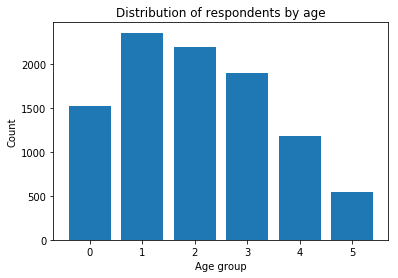

In [19]:
grp = [i for i in range(6)]
num = [1520, 2355, 2194, 1892, 1178, 541]

plt.bar(grp, num)
plt.title('Distribution of respondents by age')
plt.ylabel('Count')
plt.xlabel('Age group')
plt.show()

In [20]:
!python Scripts/distinct.py Data/Wikipedia_Editor_Survey_2012_-_anonymized_dataset_clean.csv --quiet

[0, 0]	639
[0, 1]	364
[0, 2]	230
[0, 3]	102
[0, 4]	87
[0, 5]	98
[1, 0]	941
[1, 1]	502
[1, 2]	373
[1, 3]	142
[1, 4]	212
[1, 5]	185
[2, 0]	879
[2, 1]	483
[2, 2]	326
[2, 3]	128
[2, 4]	199
[2, 5]	179
[3, 0]	754
[3, 1]	385
[3, 2]	292
[3, 3]	115
[3, 4]	195
[3, 5]	151
[4, 0]	502
[4, 1]	228
[4, 2]	145
[4, 3]	76
[4, 4]	134
[4, 5]	93
[5, 0]	258
[5, 1]	96
[5, 2]	51
[5, 3]	29
[5, 4]	46
[5, 5]	61


In [21]:
!python Scripts/corr.py Data/Wikipedia_Editor_Survey_2012_-_anonymized_dataset_clean.csv --quiet

0.026134354852822218


In [22]:
!python Scripts/full.py Data/Wikipedia_Editor_Survey_2012_-_anonymized_dataset_clean.csv --quiet

[0, 1]	0.9928116386919172
[0, 2]	0.9933531033027022
[0, 3]	0.9858447779873775
[0, 4]	0.9688035403827465
[0, 5]	0.9443269500621938
[1, 2]	0.9990574764691498
[1, 3]	0.9984471948737677
[1, 4]	0.9845492408739116
[1, 5]	0.9594218985507887
[2, 3]	0.9974427545837445
[2, 4]	0.9862111614846265
[2, 5]	0.963207738890576
[3, 4]	0.991212737832553
[3, 5]	0.9664036962002395
[4, 5]	0.984966300856087


# SQLite Answers

In [23]:
class Sql:
    # Static values
    table = "wiki"
    fields = ["id", "age", "time"]
    datapath = 'Data/Wikipedia_Editor_Survey_2012_-_anonymized_dataset_clean.csv'
    
    # Generate table(columns) string (for population)
    # optionally with types (for table creation)
    def table_cmd(self, crt = False):
        fld = ''
        for i,field in enumerate(self.fields):
            prmkey = ' PRIMARY KEY' if crt and i == 0 else ''
            fldtyp = ' INTEGER' + prmkey if crt else ''
            fld += field + fldtyp + ', '
        return f'{self.table}({fld[:-2]})'

    # Shortcut for executing on cursor and committing to db
    # optionally without printing the query command.
    def exe(self, cmd, verbose = True):
        cmd = dedent(cmd)
        c = self.db.cursor()
        if verbose:
            print(cmd)
        c.execute(cmd + ';')
        self.db.commit()
        return c
    
    # Sets up database, creates and populates table if none is found already,
    # optionally by forcing the database to reload from file.
    def __init__(self, databaseName, reloadDb = False):
        self.db = sqlite3.connect(databaseName)
        self.addFuncs()
        
        tableCheck = self.exe(f'SELECT name FROM sqlite_master WHERE type="table" AND name="{self.table}"', False).fetchone()
        if reloadDb and tableCheck:
            self.exe(f'DROP TABLE {self.table}')
        if reloadDb or not tableCheck:
            self.exe(f'CREATE TABLE {self.table_cmd(crt=True)}')
            self.populate()
    
    # Populates table FROM file given in the static path
    def populate(self):
        with open(self.datapath) as file:
            print("Populating from file: "+self.datapath)
            for i,line in enumerate(file):
                cmd = f'INSERT INTO {self.table_cmd()} VALUES ({i},{line.rstrip()})'
                self.exe(cmd, verbose=False)
            print(f"Populating completed, {i} lines loaded.")
    
    # Adds non-native support for power and squareroot functions to the database
    def addFuncs(self):
        def power(a,b):
            return float(a)**float(b)
        
        def sqrt(a):
            return float(a)**0.5
        
        self.db.create_function("POW",2,power)
        self.db.create_function("SQRT",1,sqrt)
    
    # Generates query sub-string for extracting age into bins
    # tabs are purely flavour for printing prettily.
    def agebin(self, tabs=0):
        age = self.fields[1] # "age"
        agebounds = getUpperBounds()[0]
        substring = f"""
            CASE
                WHEN {age} < {agebounds[0]} THEN 0
                WHEN {age} < {agebounds[1]} THEN 1
                WHEN {age} < {agebounds[2]} THEN 2
                WHEN {age} < {agebounds[3]} THEN 3
                WHEN {age} < {agebounds[4]} THEN 4
                ELSE 5
            END"""
        return indent(dedent(substring)[1:]," "*4*tabs)[4*tabs:]
    
    # Generates query sub-string for extracting time into bins
    # tabs are purely flavour for printing prettily.
    def timebin(self, tabs=0):
        time = self.fields[2] # "time"
        timebounds = getUpperBounds()[1]
        substring = f"""
            CASE
                WHEN {time} < {timebounds[0]} THEN 0
                WHEN {time} < {timebounds[1]} THEN 1
                WHEN {time} < {timebounds[2]} THEN 2
                WHEN {time} < {timebounds[3]} THEN 3
                WHEN {time} < {timebounds[4]} THEN 4
                ELSE 5
            END"""
        return indent(dedent(substring)[1:]," "*4*tabs)[4*tabs:]
    
    # Execute query for counting populations of distinct age groups
    def count_age_groups(self):
        table = self.table # "wiki"
        command = f"""
            SELECT
                {self.agebin(tabs=4)} AS agebin,
                COUNT(*)
            FROM
                {table}
            GROUP BY
                agebin
        """
        return self.exe(command).fetchall()
    
    # Execute query for counting distinct grouped answers
    def count_distinct_grouped_answers(self):
        table = self.table # "wiki"
        command = f"""
            SELECT
                {self.agebin(tabs=4)} AS agebin,
                {self.timebin(tabs=4)} AS timebin,
                COUNT(*)
            FROM
                {table}
            GROUP BY
                agebin, timebin
        """
        return self.exe(command).fetchall()
    
    # Execute query for finding pearson correlation
    # between the age and the time column
    def pearson_age_time_correlation(self):
        table = self.table # "wiki"
        command = f"""
            SELECT
                ( xy-x*y/n ) / SQRT( ( xx-POW(x,2)/n ) * ( yy-POW(y,2)/n ) )
            FROM (
                SELECT
                    COUNT(*) AS n,
                    SUM(xi) AS x,
                    SUM(xi*xi) AS xx,
                    SUM(xi*yi) AS xy,
                    SUM(yi) AS y,
                    SUM(yi*yi) AS yy
                FROM (
                    SELECT
                        {self.agebin(tabs=6)} AS xi,
                        {self.timebin(tabs=6)} AS yi
                    FROM
                        {table}
                )
            )
        """
        return self.exe(command).fetchone()
    
    # Execute query for finding pearson correlation
    # between time values for age group-pairs.
    def pearson_agegroup_correlations(self):
        table = self.table # "wiki"       
        command = f"""
            WITH distinct_grouped_answers AS (
                SELECT
                    {self.agebin(tabs=5)} AS agebin,
                    {self.timebin(tabs=5)} AS timebin,
                    COUNT(*) AS i
                FROM
                    {table}
                GROUP BY
                    agebin, timebin
            )
            SELECT
                agex,
                agey,
                ( xy-x*y/n ) / SQRT( ( xx-POW(x,2)/n ) * ( yy-POW(y,2)/n ) )
            FROM (
                SELECT
                    x.agebin AS agex,
                    y.agebin AS agey,
                    COUNT(*) AS n,
                    SUM(x.i) AS x,
                    SUM(x.i*x.i) AS xx,
                    SUM(x.i*y.i) AS xy,
                    SUM(y.i) AS y,
                    SUM(y.i*y.i) AS yy
                FROM
                    distinct_grouped_answers AS x
                LEFT JOIN
                    distinct_grouped_answers AS y
                ON
                    x.timebin = y.timebin
                WHERE
                    x.agebin < y.agebin
                GROUP BY
                    x.agebin, y.agebin
            )
        """
        return self.exe(command).fetchall()
    
    def close(self):
        self.db.close()

### Test

In [24]:
#sql = Sql('Sqlite/test.sqlite', reloadDb=True)
#sql.close()

In [25]:
sql = Sql('Sqlite/test.sqlite', reloadDb=False)

In [26]:
sql.count_age_groups()


SELECT
    CASE
        WHEN age < 12 THEN 0
        WHEN age < 27 THEN 1
        WHEN age < 38 THEN 2
        WHEN age < 51 THEN 3
        WHEN age < 64 THEN 4
        ELSE 5
    END AS agebin,
    COUNT(*)
FROM
    wiki
GROUP BY
    agebin



[(0, 1520), (1, 2355), (2, 2194), (3, 1892), (4, 1178), (5, 541)]

In [27]:
sql.count_distinct_grouped_answers()


SELECT
    CASE
        WHEN age < 12 THEN 0
        WHEN age < 27 THEN 1
        WHEN age < 38 THEN 2
        WHEN age < 51 THEN 3
        WHEN age < 64 THEN 4
        ELSE 5
    END AS agebin,
    CASE
        WHEN time < 1 THEN 0
        WHEN time < 3 THEN 1
        WHEN time < 6 THEN 2
        WHEN time < 10 THEN 3
        WHEN time < 16 THEN 4
        ELSE 5
    END AS timebin,
    COUNT(*)
FROM
    wiki
GROUP BY
    agebin, timebin



[(0, 0, 639),
 (0, 1, 364),
 (0, 2, 230),
 (0, 3, 102),
 (0, 4, 87),
 (0, 5, 98),
 (1, 0, 941),
 (1, 1, 502),
 (1, 2, 373),
 (1, 3, 142),
 (1, 4, 212),
 (1, 5, 185),
 (2, 0, 879),
 (2, 1, 483),
 (2, 2, 326),
 (2, 3, 128),
 (2, 4, 199),
 (2, 5, 179),
 (3, 0, 754),
 (3, 1, 385),
 (3, 2, 292),
 (3, 3, 115),
 (3, 4, 195),
 (3, 5, 151),
 (4, 0, 502),
 (4, 1, 228),
 (4, 2, 145),
 (4, 3, 76),
 (4, 4, 134),
 (4, 5, 93),
 (5, 0, 258),
 (5, 1, 96),
 (5, 2, 51),
 (5, 3, 29),
 (5, 4, 46),
 (5, 5, 61)]

In [28]:
sql.pearson_age_time_correlation()


SELECT
    ( xy-x*y/n ) / SQRT( ( xx-POW(x,2)/n ) * ( yy-POW(y,2)/n ) )
FROM (
    SELECT
        COUNT(*) AS n,
        SUM(xi) AS x,
        SUM(xi*xi) AS xx,
        SUM(xi*yi) AS xy,
        SUM(yi) AS y,
        SUM(yi*yi) AS yy
    FROM (
        SELECT
            CASE
                WHEN age < 12 THEN 0
                WHEN age < 27 THEN 1
                WHEN age < 38 THEN 2
                WHEN age < 51 THEN 3
                WHEN age < 64 THEN 4
                ELSE 5
            END AS xi,
            CASE
                WHEN time < 1 THEN 0
                WHEN time < 3 THEN 1
                WHEN time < 6 THEN 2
                WHEN time < 10 THEN 3
                WHEN time < 16 THEN 4
                ELSE 5
            END AS yi
        FROM
            wiki
    )
)



(0.02614244775794243,)

In [29]:
sql.pearson_agegroup_correlations()


WITH distinct_grouped_answers AS (
    SELECT
        CASE
            WHEN age < 12 THEN 0
            WHEN age < 27 THEN 1
            WHEN age < 38 THEN 2
            WHEN age < 51 THEN 3
            WHEN age < 64 THEN 4
            ELSE 5
        END AS agebin,
        CASE
            WHEN time < 1 THEN 0
            WHEN time < 3 THEN 1
            WHEN time < 6 THEN 2
            WHEN time < 10 THEN 3
            WHEN time < 16 THEN 4
            ELSE 5
        END AS timebin,
        COUNT(*) AS i
    FROM
        wiki
    GROUP BY
        agebin, timebin
)
SELECT
    agex,
    agey,
    ( xy-x*y/n ) / SQRT( ( xx-POW(x,2)/n ) * ( yy-POW(y,2)/n ) )
FROM (
    SELECT
        x.agebin AS agex,
        y.agebin AS agey,
        COUNT(*) AS n,
        SUM(x.i) AS x,
        SUM(x.i*x.i) AS xx,
        SUM(x.i*y.i) AS xy,
        SUM(y.i) AS y,
        SUM(y.i*y.i) AS yy
    FROM
        distinct_grouped_answers AS x
    LEFT JOIN
        distinct_grouped_answers AS y
    ON
       

[(0, 1, 0.9928116386919172),
 (0, 2, 0.9933541904648534),
 (0, 3, 0.9858473727356802),
 (0, 4, 0.9688074028353647),
 (0, 5, 0.9443305507628293),
 (1, 2, 0.9990574764691498),
 (1, 3, 0.9984471948737677),
 (1, 4, 0.9845492408739116),
 (1, 5, 0.9594258048167889),
 (2, 3, 0.9974437541485753),
 (2, 4, 0.9862126494022766),
 (2, 5, 0.9632132872263702),
 (3, 4, 0.9912162890707874),
 (3, 5, 0.9664070067769718),
 (4, 5, 0.9849712288661577)]

In [30]:
sql.close()